In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sms-spam-collection-dataset/spam.csv


In [4]:
df=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Feature

In [7]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [11]:
df= pd.concat([df['v1'], df['v2']], axis=1)

In [12]:
df.columns=['cls','text']

In [13]:
df.head()

,cls,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Checking duplicates

In [17]:
df.duplicated().sum()

403

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

0

# Encoding class

In [21]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [23]:
df['cls']=le.fit_transform(df['cls'])

In [24]:
df.cls.value_counts()

cls
0    4516
1     653
Name: count, dtype: int64

In [25]:
df.head()

,cls,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
df_ham=df[df['cls']==0]
df_spam=df[df['cls']==1]
df_ham.head(),df_spam.head()

(   cls                                               text
 0    0  Go until jurong point, crazy.. Available only ...
 1    0                      Ok lar... Joking wif u oni...
 3    0  U dun say so early hor... U c already then say...
 4    0  Nah I don't think he goes to usf, he lives aro...
 6    0  Even my brother is not like to speak with me. ...,
     cls                                               text
 2     1  Free entry in 2 a wkly comp to win FA Cup fina...
 5     1  FreeMsg Hey there darling it's been 3 week's n...
 8     1  WINNER!! As a valued network customer you have...
 9     1  Had your mobile 11 months or more? U R entitle...
 11    1  SIX chances to win CASH! From 100 to 20,000 po...)

In [27]:
ham_text=" ".join(df_ham.text)
ham_text[:50]

'Go until jurong point, crazy.. Available only in b'

In [28]:
spam_text=" ".join(df_spam.text)
spam_text[:50]

'Free entry in 2 a wkly comp to win FA Cup final tk'

# Word Cloud

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

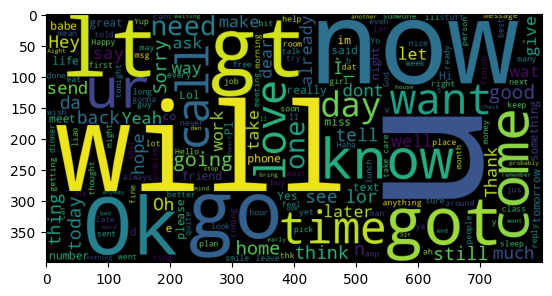

In [34]:
wc=WordCloud(width=800, height=400).generate(ham_text)
plt.imshow(wc)

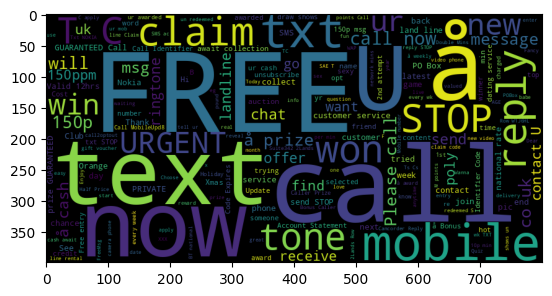

In [35]:
wc=WordCloud(width=800, height=400).generate(spam_text)
plt.imshow(wc)

# Model

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp=spacy.load('en_core_web_sm')

In [41]:
model=Pipeline([
    ('vectorizer',TfidfVectorizer(
    tokenizer= lambda text : (token.lemma_ for token in nlp(text)),
        stop_words='english',
        ngram_range=(1,2),
        max_features=500
    ))
])

In [42]:
df_prep=model.fit_transform(df['text'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(


# DL model

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_prep,df['cls'],test_size=0.2,random_state=1,stratify=df['cls'])

In [46]:
X_train.shape,X_test.shape

((4135, 500), (1034, 500))

In [49]:
max_words = df_prep.shape[1] 
max_length = df_prep.shape[1]  
max_words

500

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Embedding,Masking

In [50]:
dl_model = Sequential([
    Embedding(input_dim=max_words,output_dim=128,input_length=max_length,mask_zero=True),
    Masking(mask_value=0.0),
    LSTM(64,return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [51]:
dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
X_train = X_train.toarray()
X_test = X_test.toarray()
epochs = 10
batch_size = 64
history = dl_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
65/65 [==============================] - 75s 1s/step - loss: 0.4186 - accuracy: 0.8740 - val_loss: 0.3801 - val_accuracy: 0.8733
Epoch 2/10
65/65 [==============================] - 63s 972ms/step - loss: 0.3924 - accuracy: 0.8738 - val_loss: 0.3808 - val_accuracy: 0.8733
Epoch 3/10
65/65 [==============================] - 63s 972ms/step - loss: 0.3917 - accuracy: 0.8738 - val_loss: 0.3808 - val_accuracy: 0.8733
Epoch 4/10
65/65 [==============================] - 63s 967ms/step - loss: 0.3863 - accuracy: 0.8738 - val_loss: 0.3848 - val_accuracy: 0.8733
Epoch 5/10
65/65 [==============================] - 62s 963ms/step - loss: 0.3884 - accuracy: 0.8738 - val_loss: 0.3826 - val_accuracy: 0.8733
Epoch 6/10
65/65 [==============================] - 63s 968ms/step - loss: 0.3862 - accuracy: 0.8738 - val_loss: 0.3873 - val_accuracy: 0.8733
Epoch 7/10
65/65 [==============================] - 63s 970ms/step - loss: 0.3888 - accuracy: 0.8738 - val_loss: 0.3827 - val_accuracy: 0.8733
Ep

# Learning Curve

In [66]:
def learning_curve(history, epoch):
    # training vs validation accuracy
    epoch_range = range(1,epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

# training vs validation loss
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

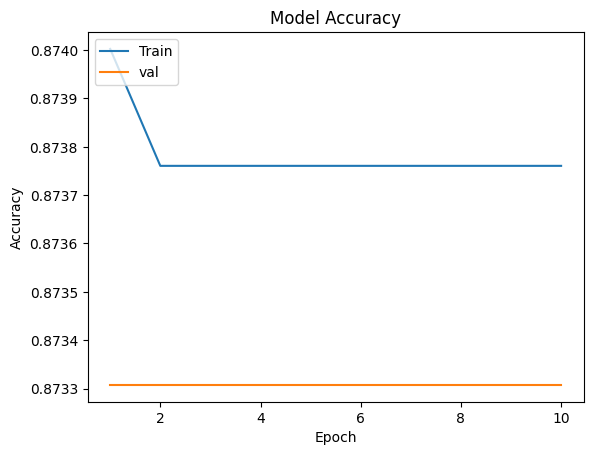

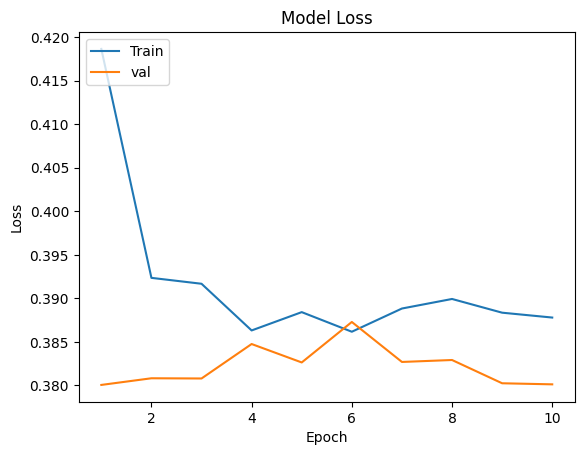

In [68]:
learning_curve(history, 10)